In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive


/content/drive/MyDrive


In [3]:
import pandas as pd

file_path="train.csv"
df = pd.read_csv(file_path)

In [4]:
df = df.dropna()

# Dropping duplicated values
# By default, this keeps the first occurrence and drops subsequent duplicates.
df = df.drop_duplicates()

len(df)

5080

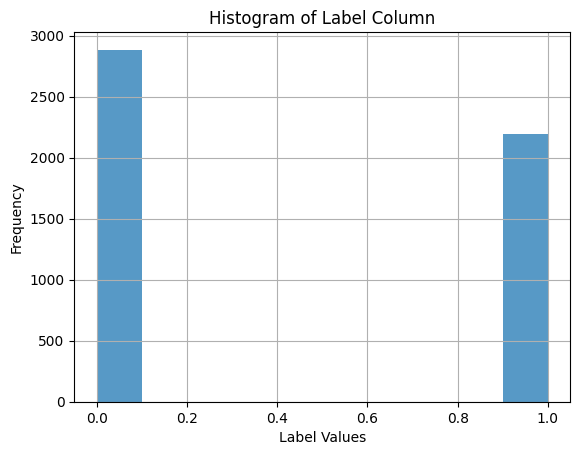

In [5]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'label' is the column name
plt.hist(df['target'], bins=10, alpha=0.75)
plt.xlabel('Label Values')
plt.ylabel('Frequency')
plt.title('Histogram of Label Column')
plt.grid(True)
plt.show()

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(document):
    document = re.sub(r'https?://\S+|www\.\S+', '', document)
    document = re.sub(r'@\w+', '', document)  # Remove mentions
    document = re.sub(r'#\w+', '', document)  # Remove hashtags (or keep hashtags but remove '#' symbol)
    document = re.sub(r'[^a-zA-Z0-9\s]', '', document)
    document = re.sub(r'\d+', '', document)

    tokens = word_tokenize(document)
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word for word in tokens if len(word) > 2]  # Remove tokens with less than 3 letters
    tokens = [word.lower() for word in tokens]  # Lowercase all tokens
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens


# Après avoir appliqué clean_text à chaque document
corpus = [' '.join(clean_text(doc)) for doc in df['text']]
corpus_str = ' '.join(corpus)
unique_tokens = set(word_tokenize(corpus_str))
print(f"Nombre de tokens uniques: {len(unique_tokens)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Nombre de tokens uniques: 10356


In [7]:
from collections import Counter

token_counts = Counter(word_tokenize(corpus_str))
#Supprimer les mots qui apparaissent moins de 3 fois
reduced_vocab = [token for token, count in token_counts.items() if count >= 3]
print(f"Nombre de token apres la reduction :",len(reduced_vocab))
single_tokens = [token for token, count in token_counts.items() if count == 1]
print(f"Nombre de tokens qui apparaissent une seule fois: {len(single_tokens)}")

Nombre de token apres la reduction : 2918
Nombre de tokens qui apparaissent une seule fois: 5963


In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
lemmatized_corpus = [' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(doc)]) for doc in reduced_vocab]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
def process_document(document):

    # Tokenize and clean the document
    tokens = clean_text(document)
    # Lemmatize the tokens if they are in the reduced vocabulary
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word in reduced_vocab]
    # Combine tokens back into a string
    return ' '.join(lemmatized_tokens)

# "Au-dessus j'ai appliqué preprocessing qui etait fait dans le TP precedent"






In [10]:
df['processed_text'] = df['text'].apply(process_document)


In [11]:
df.head()

,id,keyword,location,text,target,processed_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,wholesale market ablaze
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,break flag set ablaze aba
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry set ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from gensim.models import FastText, Word2Vec
import matplotlib.pyplot as plt
import numpy as np

# Define a function to load GloVe model
def load_glove_model(file):
    model = {}
    with open(file, 'r', encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            model[word] = embedding
    return model



def vectorize_text(texts, model):
    vectorized_texts = []
    for text in texts:
        words = text.split()
        if hasattr(model, 'wv'):  # Check if the model is a Gensim model
            vector = np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(model.vector_size)], axis=0)
        else:  # Handle dictionary type models (like GloVe)
            vector = np.mean([model[word] for word in words if word in model] or [np.zeros(100)], axis=0)
        vectorized_texts.append(vector)
    return np.array(vectorized_texts)



# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['target'], test_size=0.3, random_state=42)

# Load GloVe model (you should specify the correct path to your GloVe file)
glove_model = load_glove_model('glove.6B.100d.txt')

# Train FastText and Word2Vec models on your dataset
tokenized_train = [text.split() for text in X_train]
fasttext_model = FastText(tokenized_train, vector_size=100, window=5, min_count=5, workers=4)
word2vec_model = Word2Vec(tokenized_train, vector_size=100, window=5, min_count=5, workers=4)

# Vectorization using embeddings
embedding_models = {
    "FastText": fasttext_model,
    "GloVe": glove_model,
    "Word2Vec": word2vec_model.wv
}



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-28-0e8cc65d3ba9>:36: FutureWarning: In a future v

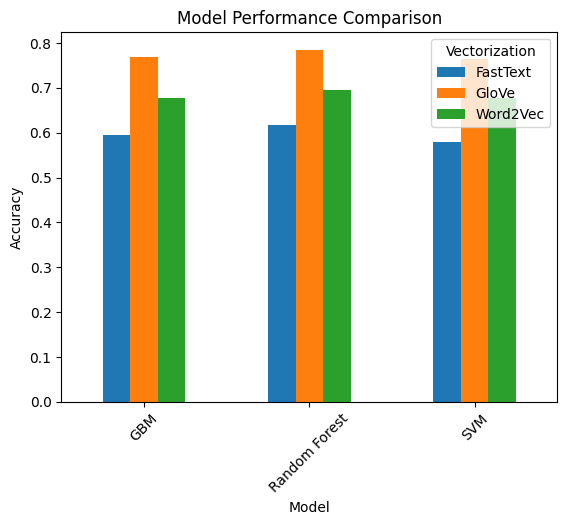

In [28]:


model_params = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {'n_estimators': [10, 50, 100, 200]}
    },
    "GBM": {
        "model": GradientBoostingClassifier(),
        "params": {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}
    },
    "SVM": {
        "model": SVC(),
        "params": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    }
}
results = []
classification_reports = {}
predictions = {}

# Applying Vectorization with Embeddings and Model Training with Grid Search
for vect_name, embedding_model in embedding_models.items():
    X_train_vect = vectorize_text(X_train, embedding_model)
    X_test_vect = vectorize_text(X_test, embedding_model)

    for model_name, mp in model_params.items():
        grid_search = GridSearchCV(mp['model'], mp['params'], cv=5)
        grid_search.fit(X_train_vect, y_train)
        y_pred = grid_search.predict(X_test_vect)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        results.append((vect_name, model_name, accuracy))
        classification_reports[(vect_name, model_name)] = report
        predictions[(vect_name, model_name)] = y_pred

# Plotting the results
df_results = pd.DataFrame(results, columns=['Vectorization', 'Model', 'Accuracy'])
df_pivot = df_results.pivot("Model", "Vectorization", "Accuracy")
df_pivot.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# "On peut voir que le modèle le plus performant est le Random Forest en utilisant la methode de embedding Glove.Le pire perfomant cest SVM en utilisant FastText"

--- Classification Report: Random Forest with FastText ---

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       884
           1       0.56      0.41      0.48       640

    accuracy                           0.62      1524
   macro avg       0.60      0.59      0.59      1524
weighted avg       0.61      0.62      0.61      1524



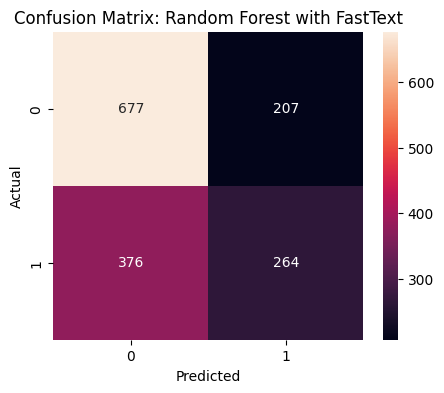

--- Classification Report: GBM with FastText ---

              precision    recall  f1-score   support

           0       0.63      0.74      0.68       884
           1       0.52      0.39      0.45       640

    accuracy                           0.59      1524
   macro avg       0.57      0.57      0.56      1524
weighted avg       0.58      0.59      0.58      1524



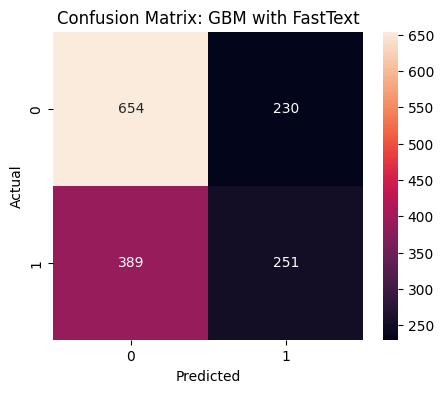

--- Classification Report: SVM with FastText ---

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       884
           1       0.00      0.00      0.00       640

    accuracy                           0.58      1524
   macro avg       0.29      0.50      0.37      1524
weighted avg       0.34      0.58      0.43      1524



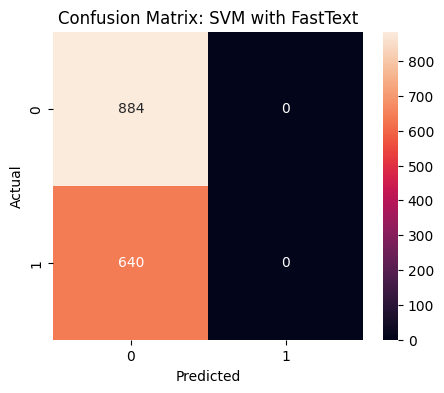

--- Classification Report: Random Forest with GloVe ---

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       884
           1       0.78      0.67      0.72       640

    accuracy                           0.78      1524
   macro avg       0.78      0.77      0.77      1524
weighted avg       0.78      0.78      0.78      1524



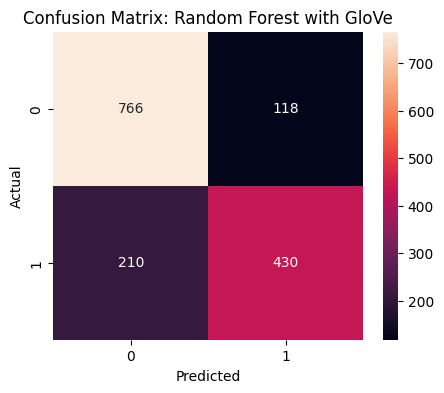

--- Classification Report: GBM with GloVe ---

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       884
           1       0.74      0.70      0.72       640

    accuracy                           0.77      1524
   macro avg       0.76      0.76      0.76      1524
weighted avg       0.77      0.77      0.77      1524



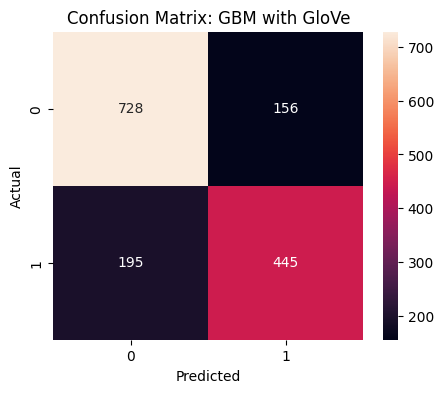

--- Classification Report: SVM with GloVe ---

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       884
           1       0.74      0.67      0.71       640

    accuracy                           0.76      1524
   macro avg       0.76      0.75      0.75      1524
weighted avg       0.76      0.76      0.76      1524



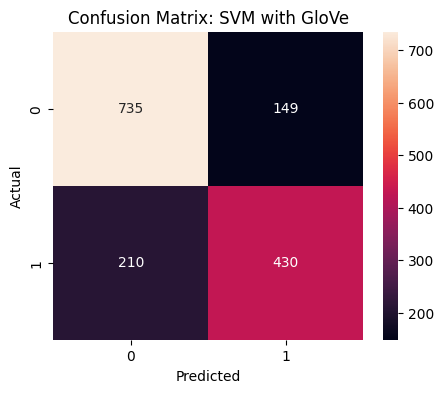

--- Classification Report: Random Forest with Word2Vec ---

              precision    recall  f1-score   support

           0       0.69      0.86      0.77       884
           1       0.71      0.47      0.56       640

    accuracy                           0.70      1524
   macro avg       0.70      0.66      0.67      1524
weighted avg       0.70      0.70      0.68      1524



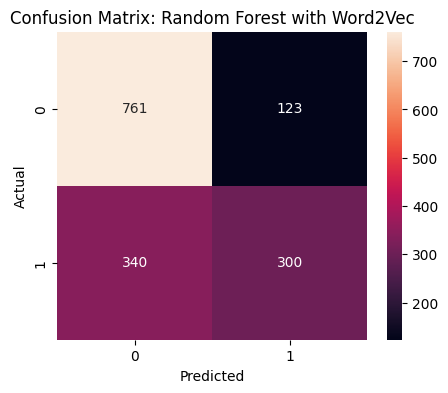

--- Classification Report: GBM with Word2Vec ---

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       884
           1       0.65      0.50      0.57       640

    accuracy                           0.68      1524
   macro avg       0.67      0.65      0.65      1524
weighted avg       0.67      0.68      0.67      1524



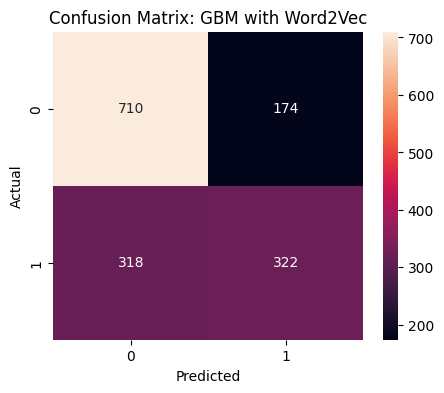

--- Classification Report: SVM with Word2Vec ---

              precision    recall  f1-score   support

           0       0.68      0.85      0.75       884
           1       0.68      0.45      0.54       640

    accuracy                           0.68      1524
   macro avg       0.68      0.65      0.65      1524
weighted avg       0.68      0.68      0.66      1524



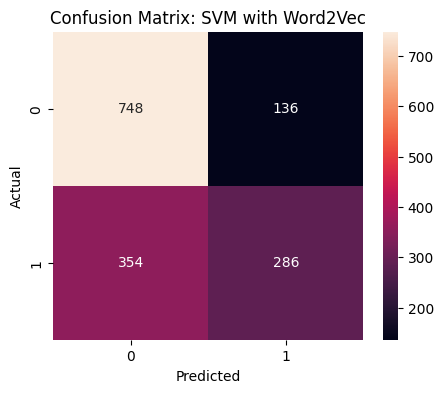

In [29]:
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Printing classification reports and plotting confusion matrices
for key, report in classification_reports.items():
    vectorizer, model = key
    print(f"--- Classification Report: {model} with {vectorizer} ---\n")
    print(report)

    # Plotting the confusion matrix
    y_pred = predictions[key]
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Confusion Matrix: {model} with {vectorizer}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# On peut constater que SVM avec Fast Text donne les resultat assez bizzard parce que on a que les resultats positif qui etaient predits.

# Le top modele donne le rsultat comme cela:
-- Classification Report: SVM with GloVe ---

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       884
           1       0.74      0.67      0.71       640

    accuracy                           0.76      1524
   macro avg       0.76      0.75      0.75      1524
weighted avg       0.76      0.76      0.76      1524


# on peut aussi voit que la meuilleure methode de embeddings c'est GLOVE